# ICLR acceptance prediction

In [1]:
from pathlib import Path
import json
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from catboost import CatBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

USE_TABPFN = True
TabPFNClassifier = None
if USE_TABPFN:
    try:
        from tabpfn import TabPFNClassifier
    except ImportError:
        USE_TABPFN = False
        print("TabPFN not installed; skipping TabPFN models.")

DATA_DIR = Path("data") / "iclr" #data from https://github.com/papercopilot/paperlists
PREDICTIONS_DIR = Path("predictions") / "iclr"
PREDICTIONS_DIR.mkdir(parents=True, exist_ok=True)

YEAR_PATHS = {
    #2023: DATA_DIR / "iclr2023.json",
    2024: DATA_DIR / "iclr2024.json",
    2025: DATA_DIR / "iclr2025.json",
    2026: DATA_DIR / "iclr2026.json",
}

# Choose which year to evaluate. All years BEFORE this one are training data.
EVAL_YEAR = 2026

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

In [2]:
DROP_COLS = [
    #"id",
    "title",
    "track",
    "status",
    "tldr",
    "abstract",
    "keywords",
    "primary_area",
    "supplementary_material",
    "author",
    "authorids",
    "gender",
    "homepage",
    "dblp",
    "google_scholar",
    "orcid",
    "linkedin",
    "or_profile",
    "aff",
    "aff_domain",
    "position",
    "bibtex",
    "github",
    "project",
    "reviewers",
    "site",
    "pdf_size",
    "gs_citation",
    "gs_cited_by_link",
    "gs_version_total",
    "aff_unique_index",
    "aff_unique_norm",
    "aff_unique_dep",
    "aff_unique_url",
    "aff_unique_abbr",
    "aff_campus_unique_index",
    "aff_campus_unique",
    "aff_country_unique_index",
    "aff_country_unique",
    "author_site",
    "openreview",
    "pdf",
    "email",
    "author_num",

    "corr_recommendation_confidence",
    "corr_recommendation_correctness",
    "corr_rating_confidence",
    "poster",
]


def _adjust_2026_ratings(series: pd.Series) -> pd.Series:
    mapping = {"0": "1", "2": "3", "4": "5"}

    def transform(value: object) -> object:
        if pd.isna(value):
            return value
        parts = str(value).split(";")
        parts = [mapping.get(part, part) for part in parts]
        return ";".join(parts)

    return series.apply(transform)


def load_year_data(
    year: int,
    path: Path,
) -> tuple[pd.DataFrame, pd.Series | None, pd.Series | None]:
    df = pd.read_json(path)
    # Align 2023 schema: recommendation == rating
    if "recommendation" in df.columns:
        df = df.rename(columns={"recommendation": "rating"})
    if year == 2026 and "rating" in df.columns:
        df["rating"] = _adjust_2026_ratings(df["rating"])
    status_raw = df.get("status")
    paper_ids = df.get("id")
    drop_cols = list(DROP_COLS)
    if EVAL_YEAR == 2026:
        # 2026 has reduced reiew respose time so these values are not comparable with previous years
        drop_cols.extend(["wc_reply_reviewers", "reply_reviewers"])
    df = df.drop(columns=drop_cols, errors="ignore")
    return df, status_raw, paper_ids


raw_by_year = {}
status_by_year = {}
ids_by_year = {}

for year, path in YEAR_PATHS.items():
    raw_by_year[year], status_by_year[year], ids_by_year[year] = load_year_data(year, path)
    print(f"{year} rows:", len(raw_by_year[year]))

raw_by_year[EVAL_YEAR].head()

2024 rows: 7407
2025 rows: 11677
2026 rows: 19622


,id,rating,confidence,soundness,contribution,presentation,wc_summary,wc_strengths,wc_weaknesses,wc_questions,wc_review,wc_reply_authors,reply_authors,rating_avg,confidence_avg,soundness_avg,contribution_avg,presentation_avg,wc_summary_avg,wc_strengths_avg,wc_weaknesses_avg,wc_questions_avg,wc_review_avg,wc_reply_reviewers_avg,wc_reply_authors_avg,reply_reviewers_avg,reply_authors_avg,replies_avg,authors#_avg
0,00F7BfXLYJ,5;5;5;5,4;5;4;3,3;2;2;3,1;2;2;2,3;3;3;2,21;49;180;55,63;23;56;76,396;261;61;151,44;117;62;6,524;450;359;288,0;0;0;0,0;0;0;0,"[4.0, 0.0]","[4.0, 0.707106781186547]","[2.5, 0.5]","[1.75, 0.433012701892219]","[2.75, 0.433012701892219]","[76.25, 61.25918298508396]","[54.5, 19.551214796017153]","[217.25, 125.16863624726443]","[57.25, 39.983590384056306]","[405.25, 89.42979089766452]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[5, 0]","[7, 0]"
1,00HNN8O7Ni,3;3;5;5,4;2;4;3,3;2;3;2,2;2;2;2,3;2;3;2,221;44;83;76,161;13;53;49,160;120;55;123,157;9;59;32,699;186;250;280,0;0;0;0,0;0;0;0,"[3.0, 1.0]","[3.25, 0.82915619758885]","[2.5, 0.5]","[2.0, 0.0]","[2.5, 0.5]","[106.0, 68.00367637120804]","[69.0, 55.35341001239219]","[114.5, 37.79219496139381]","[64.25, 56.397584168118414]","[353.75, 202.20085929589914]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[8, 0]","[0, 0]"
2,00UQtHqB2k,3;3;5;6,4;3;4;4,2;2;3;3,1;2;2;3,2;2;3;3,87;99;60;171,35;77;29;64,106;209;128;280,187;161;19;40,415;546;236;555,0;0;0;0,0;0;0;0,"[3.5, 1.6583123951777]","[3.75, 0.433012701892219]","[2.5, 0.5]","[2.0, 0.707106781186547]","[2.5, 0.5]","[104.25, 41.04494487753638]","[51.25, 19.904459299363044]","[180.75, 68.95424207400151]","[101.75, 73.20988662742212]","[438.0, 129.11816293612608]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[9, 0]","[0, 0]"
3,017F77AYeQ,1;3;3;5,5;5;4;4,1;2;1;3,1;1;1;2,1;3;2;3,1;31;12;63,1;44;12;50,34;125;103;124,1;63;3;62,37;263;130;299,0;0;0;0,0;0;0;0,"[2.0, 1.414213562373095]","[4.5, 0.5]","[1.75, 0.82915619758885]","[1.25, 0.433012701892219]","[2.25, 0.82915619758885]","[26.75, 23.519938350259338]","[26.75, 20.72890493972125]","[96.5, 37.13825520941984]","[32.25, 30.26032881513352]","[182.25, 104.85555540838072]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[5, 0]","[2, 0]"
4,023yMrtHQP,5;5;5,3;3;4,2;3;2,2;2;2,3;3;3,101;167;79,63;59;38,40;90;251,75;73;3,279;389;371,0;0;0,0;0;0,"[4.0, 0.0]","[3.333333333333333, 0.471404520791031]","[2.333333333333333, 0.471404520791031]","[2.0, 0.0]","[3.0, 0.0]","[115.66666666666667, 37.392809766347085]","[53.333333333333336, 10.964589468932349]","[127.0, 90.02592219281438]","[50.333333333333336, 33.47967874530592]","[346.3333333333333, 48.17560470703911]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[3, 0]","[0, 0]"


In [3]:
raw_by_year[2024].head()

,id,rating,confidence,soundness,contribution,presentation,wc_summary,wc_strengths,wc_weaknesses,wc_questions,wc_review,wc_reply_authors,reply_authors,rating_avg,confidence_avg,soundness_avg,contribution_avg,presentation_avg,wc_summary_avg,wc_strengths_avg,wc_weaknesses_avg,wc_questions_avg,wc_review_avg,wc_reply_reviewers_avg,wc_reply_authors_avg,reply_reviewers_avg,reply_authors_avg,replies_avg,authors#_avg
0,0074qaufB6,1;3;5,4;3;4,2;3;2,1;2;2,2;2;3,97;80;124,49;53;168,350;172;196,48;41;182,544;346;670,0;0;0,0;0;0,"[3.0, 1.632993161855452]","[3.666666666666666, 0.471404520791031]","[2.333333333333333, 0.471404520791031]","[1.666666666666666, 0.471404520791031]","[2.333333333333333, 0.471404520791031]","[100.33333333333333, 18.116904322268255]","[90.0, 55.17849822772152]","[239.33333333333334, 78.86415887813396]","[90.33333333333333, 64.88108781112996]","[520.0, 133.3566646253572]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[3, 0]","[2, 0]"
1,014CgNPAGy,3;5;5;6,4;5;4;3,1;1;3;3,1;1;2;3,2;3;3;3,47;156;94;104,31;8;15;95,219;937;242;65,6;53;5;6,303;1154;356;270,514;2139;1249;161,1;4;3;1,"[4.75, 1.089724735885168]","[4.0, 0.707106781186547]","[2.0, 1.0]","[1.75, 0.82915619758885]","[2.75, 0.433012701892219]","[100.25, 38.71934271136327]","[37.25, 34.368408458932166]","[365.75, 336.7590941607962]","[17.5, 20.5]","[520.75, 366.8919289109533]","[293.75, 356.01009466024976]","[1015.75, 758.0314554818949]","[1.25, 0.433012701892219]","[2.25, 1.299038105676658]","[20, 0]","[2, 0]"
2,01Yi8rzoNs,3;3;5;6,4;4;4;4,2;2;2;3,2;2;2;3,2;3;2;3,136;55;76;74,27;31;117;55,285;261;411;235,4;21;109;52,452;368;713;416,0;0;0;0,0;0;0;0,"[4.25, 1.299038105676658]","[4.0, 0.0]","[2.25, 0.433012701892219]","[2.25, 0.433012701892219]","[2.5, 0.5]","[85.25, 30.425112982534674]","[57.5, 35.98263470064414]","[298.0, 67.59437846448475]","[46.5, 39.978119015281344]","[487.25, 133.69999065071022]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[4, 0]","[10, 0]"
3,01ep65umEr,5;5;5;6,3;4;3;5,2;3;2;2,2;3;2;3,2;3;2;3,96;37;46;90,104;13;59;51,196;184;86;250,1;4;98;6,397;238;289;397,499;672;771;668,1;1;1;1,"[5.25, 0.433012701892219]","[3.75, 0.82915619758885]","[2.25, 0.433012701892219]","[2.5, 0.5]","[2.5, 0.5]","[67.25, 26.03243169586737]","[56.75, 32.34482184214345]","[179.0, 59.16924876994806]","[27.25, 40.88627520330019]","[330.25, 69.14251586397475]","[21.5, 37.239092362730865]","[652.5, 97.75607398008576]","[0.25, 0.433012701892219]","[1.0, 0.0]","[12, 0]","[4, 0]"
4,02Ug9N8DCI,3;3;3;5,4;4;4;5,2;1;1;3,1;2;3;2,2;2;2;2,110;38;40;104,72;15;38;94,275;9;167;159,2;310;33;278,459;372;278;635,0;0;0;0,0;0;0;0,"[3.5, 0.866025403784438]","[4.25, 0.433012701892219]","[1.75, 0.82915619758885]","[2.0, 0.707106781186547]","[2.0, 0.0]","[73.0, 34.07345007480164]","[54.75, 30.408674749156695]","[152.5, 94.67180150393253]","[155.75, 139.1444842600669]","[436.0, 131.51996046228115]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[6, 0]","[1, 0]"


In [4]:
raw_by_year[2026].head()

,id,rating,confidence,soundness,contribution,presentation,wc_summary,wc_strengths,wc_weaknesses,wc_questions,wc_review,wc_reply_authors,reply_authors,rating_avg,confidence_avg,soundness_avg,contribution_avg,presentation_avg,wc_summary_avg,wc_strengths_avg,wc_weaknesses_avg,wc_questions_avg,wc_review_avg,wc_reply_reviewers_avg,wc_reply_authors_avg,reply_reviewers_avg,reply_authors_avg,replies_avg,authors#_avg
0,00F7BfXLYJ,5;5;5;5,4;5;4;3,3;2;2;3,1;2;2;2,3;3;3;2,21;49;180;55,63;23;56;76,396;261;61;151,44;117;62;6,524;450;359;288,0;0;0;0,0;0;0;0,"[4.0, 0.0]","[4.0, 0.707106781186547]","[2.5, 0.5]","[1.75, 0.433012701892219]","[2.75, 0.433012701892219]","[76.25, 61.25918298508396]","[54.5, 19.551214796017153]","[217.25, 125.16863624726443]","[57.25, 39.983590384056306]","[405.25, 89.42979089766452]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[5, 0]","[7, 0]"
1,00HNN8O7Ni,3;3;5;5,4;2;4;3,3;2;3;2,2;2;2;2,3;2;3;2,221;44;83;76,161;13;53;49,160;120;55;123,157;9;59;32,699;186;250;280,0;0;0;0,0;0;0;0,"[3.0, 1.0]","[3.25, 0.82915619758885]","[2.5, 0.5]","[2.0, 0.0]","[2.5, 0.5]","[106.0, 68.00367637120804]","[69.0, 55.35341001239219]","[114.5, 37.79219496139381]","[64.25, 56.397584168118414]","[353.75, 202.20085929589914]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[8, 0]","[0, 0]"
2,00UQtHqB2k,3;3;5;6,4;3;4;4,2;2;3;3,1;2;2;3,2;2;3;3,87;99;60;171,35;77;29;64,106;209;128;280,187;161;19;40,415;546;236;555,0;0;0;0,0;0;0;0,"[3.5, 1.6583123951777]","[3.75, 0.433012701892219]","[2.5, 0.5]","[2.0, 0.707106781186547]","[2.5, 0.5]","[104.25, 41.04494487753638]","[51.25, 19.904459299363044]","[180.75, 68.95424207400151]","[101.75, 73.20988662742212]","[438.0, 129.11816293612608]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[9, 0]","[0, 0]"
3,017F77AYeQ,1;3;3;5,5;5;4;4,1;2;1;3,1;1;1;2,1;3;2;3,1;31;12;63,1;44;12;50,34;125;103;124,1;63;3;62,37;263;130;299,0;0;0;0,0;0;0;0,"[2.0, 1.414213562373095]","[4.5, 0.5]","[1.75, 0.82915619758885]","[1.25, 0.433012701892219]","[2.25, 0.82915619758885]","[26.75, 23.519938350259338]","[26.75, 20.72890493972125]","[96.5, 37.13825520941984]","[32.25, 30.26032881513352]","[182.25, 104.85555540838072]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[5, 0]","[2, 0]"
4,023yMrtHQP,5;5;5,3;3;4,2;3;2,2;2;2,3;3;3,101;167;79,63;59;38,40;90;251,75;73;3,279;389;371,0;0;0,0;0;0,"[4.0, 0.0]","[3.333333333333333, 0.471404520791031]","[2.333333333333333, 0.471404520791031]","[2.0, 0.0]","[3.0, 0.0]","[115.66666666666667, 37.392809766347085]","[53.333333333333336, 10.964589468932349]","[127.0, 90.02592219281438]","[50.333333333333336, 33.47967874530592]","[346.3333333333333, 48.17560470703911]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[3, 0]","[0, 0]"


In [5]:
import re


def normalize_status(value: object) -> str | float:
    if pd.isna(value):
        return np.nan
    text = str(value).lower()
    if "top-5" in text:
        return "oral"
    if "top-25" in text:
        return "spotlight"
    if "accept" in text:
        return "accept"
    if "withdraw" in text:
        return "reject"
    if "reject" in text:
        return "reject"
    return text


def expand_multivalue_columns(df: pd.DataFrame, sep: str = ";", max_len: int = 8) -> pd.DataFrame:
    df = df.copy()
    multivalue_cols = []
    for col in df.columns:
        if df[col].dtype == "object":
            if df[col].fillna("").astype(str).str.contains(sep).any():
                multivalue_cols.append(col)

    new_cols = {}
    for col in multivalue_cols:
        parts = df[col].fillna("").astype(str).str.split(sep)
        for i in range(max_len):
            new_col = f"{col}_{i + 1}"
            values = parts.str[i].replace("", np.nan)
            new_cols[new_col] = pd.to_numeric(values, errors="coerce")

    if new_cols:
        df = pd.concat([df.drop(columns=multivalue_cols), pd.DataFrame(new_cols, index=df.index)], axis=1)
    else:
        df = df.drop(columns=multivalue_cols, errors="ignore")

    return df


def _group_numbered_columns(columns: pd.Index) -> dict[str, list[str]]:
    groups: dict[str, list[str]] = {}
    for col in columns:
        match = re.match(r"^(.*)_(\d+)$", col)
        if match:
            base = match.group(1)
            groups.setdefault(base, []).append(col)
    for base, cols in groups.items():
        groups[base] = sorted(cols, key=lambda name: int(name.rsplit("_", 1)[1]))
    return groups


def add_multivalue_summary_stats(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    groups = _group_numbered_columns(df.columns)
    for base, cols in groups.items():
        if len(cols) < 2:
            continue
        values = df[cols].apply(pd.to_numeric, errors="coerce")
        df[f"{base}_mean"] = values.mean(axis=1, skipna=True)
        df[f"{base}_std"] = values.std(axis=1, ddof=0, skipna=True)
        if base == "rating":
            df[f"{base}_count"] = values.notna().sum(axis=1)
    return df


def _format_count_value(value: float) -> str:
    if isinstance(value, (int, np.integer)):
        return str(int(value))
    if isinstance(value, float) and float(value).is_integer():
        return str(int(value))
    return str(value).replace(".", "_")


def add_multivalue_value_counts(
    df: pd.DataFrame,
    base_names: list[str],
) -> pd.DataFrame:
    df = df.copy()
    groups = _group_numbered_columns(df.columns)
    for base in base_names:
        cols = groups.get(base, [])
        if not cols:
            continue
        values = df[cols].apply(pd.to_numeric, errors="coerce")
        stacked = values.stack(future_stack=True)
        if stacked.empty:
            continue
        unique_vals = sorted(stacked.unique())
        denom = None
        if "rating_count" in df.columns:
            denom = df["rating_count"].replace(0, np.nan)
        for val in unique_vals:
            label = _format_count_value(val)
            counts = (values == val).sum(axis=1)
            if denom is not None:
                counts = counts / denom
            df[f"{base}_count_{label}"] = counts
    return df


def add_year_mean_deltas(
    df: pd.DataFrame,
    year: int | None,
    mean_suffix: str = "_mean",
) -> pd.DataFrame:
    if year is None:
        return df
    df = df.copy()
    mean_cols = [col for col in df.columns if col.endswith(mean_suffix)]
    if not mean_cols:
        return df
    year_means = df[mean_cols].mean(skipna=True)
    for col in mean_cols:
        df[f"{col}_year_delta"] = df[col] - year_means[col]
    return df


def keep_numeric_columns(
    df: pd.DataFrame,
    drop_cols: list[str] | None = None,
    min_numeric_ratio: float = 0.8,
) -> pd.DataFrame:
    drop_cols = set(drop_cols or [])
    df = df.copy()

    numeric_df = df.select_dtypes(include=[np.number]).copy()

    for col in df.columns:
        if col in drop_cols or col in numeric_df.columns:
            continue
        if df[col].dtype == "object" and col not in ["status_norm", "poster"]:
            coerced = pd.to_numeric(df[col], errors="coerce")
            ratio = coerced.notna().mean()
            if ratio >= min_numeric_ratio:
                numeric_df[col] = coerced

    return numeric_df


def drop_constant_or_nan_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    nunique = df.nunique(dropna=True)
    keep_cols = nunique[nunique > 1].index
    return df.loc[:, keep_cols]


def align_train_eval_columns(
    X_train: pd.DataFrame,
    X_eval: pd.DataFrame,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    common_cols = X_train.columns.intersection(X_eval.columns)
    X_train = X_train.loc[:, common_cols]
    X_eval = X_eval.loc[:, common_cols]
    X_train = drop_constant_or_nan_columns(X_train)
    X_eval = X_eval.reindex(columns=X_train.columns)
    return X_train, X_eval


def apply_ranked_acceptance_tiers(
    results_df: pd.DataFrame,
    proba_cols: list[str],
    top_oral: float = 0.05,
    top_spotlight: float = 0.25,
) -> tuple[pd.Series, pd.Series]:
    if results_df.empty:
        return pd.Series(dtype=object), pd.Series(dtype=float)

    non_reject_cols = [col for col in proba_cols if col != "proba_reject"]
    if non_reject_cols:
        accept_score = results_df[non_reject_cols].sum(axis=1)
    else:
        accept_score = results_df[proba_cols].max(axis=1)

    ranked = np.where(results_df["pred_status"] == "reject", "reject", "poster")
    ranked = pd.Series(ranked, index=results_df.index)

    order = accept_score.sort_values(ascending=False).index
    n = len(results_df)
    n_oral = max(1, int(np.ceil(n * top_oral)))
    n_spotlight = max(n_oral, int(np.ceil(n * top_spotlight)))

    ranked.loc[order[:n_oral]] = "oral"
    ranked.loc[order[n_oral:n_spotlight]] = "spotlight"

    return ranked, accept_score

In [6]:
def prepare_features(
    df: pd.DataFrame,
    status_raw: pd.Series | None = None,
    year: int | None = None,
) -> tuple[pd.DataFrame, pd.Series | None]:
    df = df.copy()
    if status_raw is not None:
        df = df.assign(status_norm=status_raw.apply(normalize_status))
    expanded = expand_multivalue_columns(df)
    expanded = add_multivalue_summary_stats(expanded)
    expanded = add_multivalue_value_counts(
        expanded,
        base_names=[
            "rating",
            "confidence",
            "correctness",
            "soundness",
            "contribution",
            "presentation",
        ],
    )
    X = keep_numeric_columns(expanded, drop_cols=["status_norm"])
    X = add_year_mean_deltas(X, year)
    y_out = expanded["status_norm"] if status_raw is not None else None
    drop_prefixes = [
        "rating",
        "confidence",
        "wc_review",
        "wc_reply_authors",
        "reply_authors",
        "soundness",
        "contribution",
        "presentation",
        "wc_summary",
        "wc_strengths",
        "wc_weaknesses",
        "wc_questions",
    ]
    drop_cols = []
    drop_cols += [
        f"{prefix}_{i}" for prefix in drop_prefixes for i in range(1, 9)
    ]
    if drop_cols:
        X = X.drop(columns=drop_cols, errors="ignore")
    return X, y_out


train_years = [year for year in sorted(YEAR_PATHS) if year < EVAL_YEAR]
if not train_years:
    raise ValueError("EVAL_YEAR must be greater than the minimum year.")

train_frames = []
train_labels = []
for year in train_years:
    X_year, y_year = prepare_features(
        raw_by_year[year],
        status_by_year[year],
        year=year,
    )
    mask = y_year.notna()
    train_frames.append(X_year.loc[mask])
    train_labels.append(y_year.loc[mask])

X_train_full = pd.concat(train_frames, axis=0, ignore_index=True)
y = pd.concat(train_labels, axis=0, ignore_index=True)

X_eval, y_eval = prepare_features(
    raw_by_year[EVAL_YEAR],
    status_by_year[EVAL_YEAR],
    year=EVAL_YEAR,
)
X_train_full, X_eval = align_train_eval_columns(X_train_full, X_eval)

print("Training years:", train_years)
print("Eval year:", EVAL_YEAR)
print("Features:", X_train_full.shape[1])
print("Classes:", y.value_counts())

Training years: [2024, 2025]
Eval year: 2026
Features: 60
Classes: status_norm
reject       13120
poster        4918
spotlight      747
oral           299
Name: count, dtype: int64


In [7]:
display(X_train_full)

,rating_mean,rating_std,rating_count,confidence_mean,confidence_std,soundness_mean,soundness_std,contribution_mean,contribution_std,presentation_mean,presentation_std,wc_summary_mean,wc_summary_std,wc_strengths_mean,wc_strengths_std,wc_weaknesses_mean,wc_weaknesses_std,wc_questions_mean,wc_questions_std,wc_review_mean,wc_review_std,wc_reply_authors_mean,wc_reply_authors_std,reply_authors_mean,reply_authors_std,rating_count_1,rating_count_3,rating_count_5,rating_count_6,rating_count_8,rating_count_10,confidence_count_3,confidence_count_4,confidence_count_1,confidence_count_2,confidence_count_5,soundness_count_2,soundness_count_3,soundness_count_1,soundness_count_4,contribution_count_1,contribution_count_2,contribution_count_3,contribution_count_4,presentation_count_2,presentation_count_3,presentation_count_1,presentation_count_4,rating_mean_year_delta,confidence_mean_year_delta,soundness_mean_year_delta,contribution_mean_year_delta,presentation_mean_year_delta,wc_summary_mean_year_delta,wc_strengths_mean_year_delta,wc_weaknesses_mean_year_delta,wc_questions_mean_year_delta,wc_review_mean_year_delta,wc_reply_authors_mean_year_delta,reply_authors_mean_year_delta
0,3.00,1.632993,3,3.666667,0.471405,2.333333,0.471405,1.666667,0.471405,2.333333,0.471405,100.333333,18.116904,90.000000,55.178498,239.333333,78.864159,90.333333,64.881088,520.00,133.356665,0.00,0.000000,0.00,0.000000,0.333333,0.333333,0.333333,0.000000,0.0,0.0,0.333333,0.666667,0.0,0.0,0.00,0.666667,0.333333,0.00,0.000000,0.333333,0.666667,0.000000,0.0,0.666667,0.333333,0.0,0.0,-2.139943,0.024854,-0.279702,-0.709009,-0.307480,11.628666,27.780723,49.636577,6.972079,96.018045,-716.629028,-1.806335
1,4.75,1.089725,4,4.000000,0.707107,2.000000,1.000000,1.750000,0.829156,2.750000,0.433013,100.250000,38.719343,37.250000,34.368408,365.750000,336.759094,17.500000,20.500000,520.75,366.891929,1015.75,758.031455,2.25,1.299038,0.000000,0.250000,0.500000,0.250000,0.0,0.0,0.250000,0.500000,0.0,0.0,0.25,0.000000,0.500000,0.50,0.000000,0.500000,0.250000,0.250000,0.0,0.250000,0.750000,0.0,0.0,-0.389943,0.358187,-0.613035,-0.625675,0.109187,11.545332,-24.969277,176.053244,-65.861254,96.768045,299.120972,0.443665
2,4.25,1.299038,4,4.000000,0.000000,2.250000,0.433013,2.250000,0.433013,2.500000,0.500000,85.250000,30.425113,57.500000,35.982635,298.000000,67.594378,46.500000,39.978119,487.25,133.699991,0.00,0.000000,0.00,0.000000,0.000000,0.500000,0.250000,0.250000,0.0,0.0,0.000000,1.000000,0.0,0.0,0.00,0.750000,0.250000,0.00,0.000000,0.000000,0.750000,0.250000,0.0,0.500000,0.500000,0.0,0.0,-0.889943,0.358187,-0.363035,-0.125675,-0.140813,-3.454668,-4.719277,108.303244,-36.861254,63.268045,-716.629028,-1.806335
3,5.25,0.433013,4,3.750000,0.829156,2.250000,0.433013,2.500000,0.500000,2.500000,0.500000,67.250000,26.032432,56.750000,32.344822,179.000000,59.169249,27.250000,40.886275,330.25,69.142516,652.50,97.756074,1.00,0.000000,0.000000,0.000000,0.750000,0.250000,0.0,0.0,0.500000,0.250000,0.0,0.0,0.25,0.750000,0.250000,0.00,0.000000,0.000000,0.500000,0.500000,0.0,0.500000,0.500000,0.0,0.0,0.110057,0.108187,-0.363035,0.124325,-0.140813,-21.454668,-5.469277,-10.696756,-56.111254,-93.731955,-64.129028,-0.806335
4,3.50,0.866025,4,4.250000,0.433013,1.750000,0.829156,2.000000,0.707107,2.000000,0.000000,73.000000,34.073450,54.750000,30.408675,152.500000,94.671802,155.750000,139.144484,436.00,131.519960,0.00,0.000000,0.00,0.000000,0.000000,0.750000,0.250000,0.000000,0.0,0.0,0.000000,0.750000,0.0,0.0,0.25,0.250000,0.250000,0.50,0.000000,0.250000,0.500000,0.250000,0.0,1.000000,0.000000,0.0,0.0,-1.639943,0.608187,-0.863035,-0.375675,-0.640813,-15.704668,-7.469277,-37.196756,72.388746,12.018045,-716.629028,-1.806335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19079,5.75,0.433013,4,3.750000,0.829156,2.750000,0.4

In [8]:
def _safe_correlations(X: pd.DataFrame, y_bin: pd.Series) -> pd.Series:
    y_values = y_bin.to_numpy(dtype=float)
    y_std = np.nanstd(y_values)
    if y_std == 0:
        return pd.Series(dtype=float)
    corrs = {}
    for col in X.columns:
        x_values = X[col].to_numpy(dtype=float)
        mask = ~np.isnan(x_values)
        if mask.sum() < 2:
            continue
        x = x_values[mask]
        y = y_values[mask]
        x_std = np.nanstd(x)
        if x_std == 0:
            continue
        cov = np.nanmean((x - np.nanmean(x)) * (y - np.nanmean(y)))
        corrs[col] = cov / (x_std * y_std)
    return pd.Series(corrs)


def top_class_correlations(
    X: pd.DataFrame,
    y: pd.Series,
    top_n: int = 10,
) -> dict[str, dict[str, pd.DataFrame]]:
    results: dict[str, dict[str, pd.DataFrame]] = {}
    X_numeric = X.select_dtypes(include=[np.number]).copy()
    X_numeric = X_numeric.loc[:, X_numeric.nunique(dropna=True) > 1]
    for cls in sorted(y.dropna().unique()):
        y_bin = (y == cls).astype(int)
        corr = _safe_correlations(X_numeric, y_bin).dropna()
        negatives = corr[corr < 0].nsmallest(top_n)
        positives = corr[corr > 0].nlargest(top_n)
        results[cls] = {
            "negative": negatives.reset_index().rename(
                columns={"index": "feature", 0: "correlation"}
            ),
            "positive": positives.reset_index().rename(
                columns={"index": "feature", 0: "correlation"}
            ),
        }
    return results


corr_by_class = top_class_correlations(X_train_full, y, top_n=10)
for cls, tables in corr_by_class.items():
    print(f"\nClass: {cls}")
    print("Top negative correlations")
    display(tables["negative"])
    print("Top positive correlations")
    display(tables["positive"])



Class: oral
Top negative correlations


,feature,correlation
0,contribution_count_2,-0.174551
1,soundness_count_2,-0.140757
2,rating_count_5,-0.129928
3,rating_count_3,-0.112465
4,presentation_count_2,-0.105752
5,rating_std,-0.084928
6,contribution_count_1,-0.066296
7,rating_count_6,-0.065903
8,presentation_count_1,-0.056310
9,soundness_count_1,-0.050774


Top positive correlations


,feature,correlation
0,rating_count_8,0.362977
1,rating_count_10,0.267917
2,rating_mean,0.265246
3,rating_mean_year_delta,0.265153
4,contribution_count_4,0.251190
5,contribution_mean_year_delta,0.221114
6,contribution_mean,0.220642
7,soundness_count_4,0.206876
8,soundness_mean_year_delta,0.186319
9,soundness_mean,0.185449



Class: poster
Top negative correlations


,feature,correlation
0,rating_count_3,-0.453357
1,soundness_count_2,-0.327706
2,rating_count_5,-0.323501
3,contribution_count_2,-0.296813
4,contribution_count_1,-0.257724
5,presentation_count_2,-0.222078
6,soundness_count_1,-0.205446
7,presentation_count_1,-0.192428
8,wc_weaknesses_mean_year_delta,-0.161721
9,wc_weaknesses_mean,-0.159400


Top positive correlations


,feature,correlation
0,rating_mean,0.532358
1,rating_mean_year_delta,0.532275
2,rating_count_6,0.524365
3,contribution_mean_year_delta,0.413662
4,contribution_mean,0.413204
5,contribution_count_3,0.395899
6,soundness_mean_year_delta,0.389449
7,soundness_mean,0.388560
8,rating_count_8,0.334116
9,soundness_count_3,0.318565



Class: reject
Top negative correlations


,feature,correlation
0,rating_mean,-0.716709
1,rating_mean_year_delta,-0.716674
2,rating_count_8,-0.604468
3,contribution_mean_year_delta,-0.562896
4,contribution_mean,-0.562633
5,soundness_mean_year_delta,-0.515276
6,soundness_mean,-0.514716
7,contribution_count_3,-0.489266
8,rating_count_6,-0.478349
9,presentation_mean_year_delta,-0.413361


Top positive correlations


,feature,correlation
0,rating_count_3,0.532391
1,soundness_count_2,0.425983
2,contribution_count_2,0.421257
3,rating_count_5,0.418559
4,contribution_count_1,0.303894
5,presentation_count_2,0.292966
6,soundness_count_1,0.240702
7,presentation_count_1,0.230924
8,wc_weaknesses_mean_year_delta,0.199336
9,wc_weaknesses_mean,0.197896



Class: spotlight
Top negative correlations


,feature,correlation
0,contribution_count_2,-0.225677
1,soundness_count_2,-0.188941
2,rating_count_5,-0.187616
3,rating_count_3,-0.178007
4,presentation_count_2,-0.131652
5,contribution_count_1,-0.102645
6,wc_weaknesses_mean,-0.084454
7,presentation_count_1,-0.081895
8,wc_weaknesses_mean_year_delta,-0.081278
9,soundness_count_1,-0.079453


Top positive correlations


,feature,correlation
0,rating_count_8,0.458779
1,rating_mean_year_delta,0.342704
2,rating_mean,0.342540
3,contribution_mean,0.271571
4,contribution_mean_year_delta,0.270864
5,soundness_mean,0.235158
6,soundness_mean_year_delta,0.233936
7,contribution_count_4,0.215895
8,soundness_count_4,0.213570
9,contribution_count_3,0.202080


In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)


In [10]:
catboost_model = CatBoostClassifier(
    loss_function="MultiClass",
    eval_metric="TotalF1",
    random_seed=42,
    verbose=100,
)

catboost_model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

model = catboost_model

Learning rate set to 0.114026
0:	learn: 0.8712313	test: 0.8694433	best: 0.8694433 (0)	total: 53.7ms	remaining: 53.6s
100:	learn: 0.8930718	test: 0.8791538	best: 0.8819246 (60)	total: 650ms	remaining: 5.79s
200:	learn: 0.9075186	test: 0.8796524	best: 0.8819246 (60)	total: 1.73s	remaining: 6.89s
300:	learn: 0.9193016	test: 0.8793062	best: 0.8819246 (60)	total: 3.43s	remaining: 7.97s
400:	learn: 0.9304748	test: 0.8788736	best: 0.8819246 (60)	total: 4.05s	remaining: 6.05s
500:	learn: 0.9400939	test: 0.8785994	best: 0.8819246 (60)	total: 4.65s	remaining: 4.63s
600:	learn: 0.9493253	test: 0.8779488	best: 0.8819246 (60)	total: 5.25s	remaining: 3.49s
700:	learn: 0.9584235	test: 0.8775044	best: 0.8819246 (60)	total: 5.89s	remaining: 2.51s
800:	learn: 0.9660047	test: 0.8789955	best: 0.8819246 (60)	total: 6.52s	remaining: 1.62s
900:	learn: 0.9723139	test: 0.8759654	best: 0.8819246 (60)	total: 7.13s	remaining: 783ms
999:	learn: 0.9781501	test: 0.8773307	best: 0.8819246 (60)	total: 7.75s	remaining:

In [11]:
logreg_model = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
    LogisticRegression(
        max_iter=2000,
        n_jobs=-1,
        multi_class="multinomial",
    ),
)

logreg_model.fit(X_train, y_train)

/home/smarton/anaconda3/envs/TabArena/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=2000, multi_class='multinomial',
                                    n_jobs=-1))])

In [12]:
decision_tree_model = make_pipeline(
    SimpleImputer(strategy="median"),
    DecisionTreeClassifier(),
)

decision_tree_model.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [13]:
tabpfn_model = None
if USE_TABPFN and TabPFNClassifier is not None:
    tabpfn_model = make_pipeline(
        SimpleImputer(strategy="median"),
        TabPFNClassifier(),
    )

    tabpfn_model.fit(X_train, y_train)
else:
    print("TabPFN disabled; skipping training.")

,accuracy,macro_f1,weighted_f1,f1_oral,accuracy_oral,f1_poster,accuracy_poster,f1_reject,accuracy_reject,f1_spotlight,accuracy_spotlight
model,,,,,,,,,,,
CatBoost,0.883,0.777,0.882,0.707,0.991,0.786,0.890,0.933,0.908,0.684,0.977
TabPFN,0.880,0.777,0.877,0.714,0.992,0.772,0.887,0.931,0.904,0.688,0.977
Logistic Regression,0.874,0.732,0.872,0.667,0.990,0.774,0.881,0.932,0.906,0.554,0.971
Decision Tree,0.822,0.671,0.821,0.586,0.987,0.677,0.833,0.898,0.859,0.523,0.964


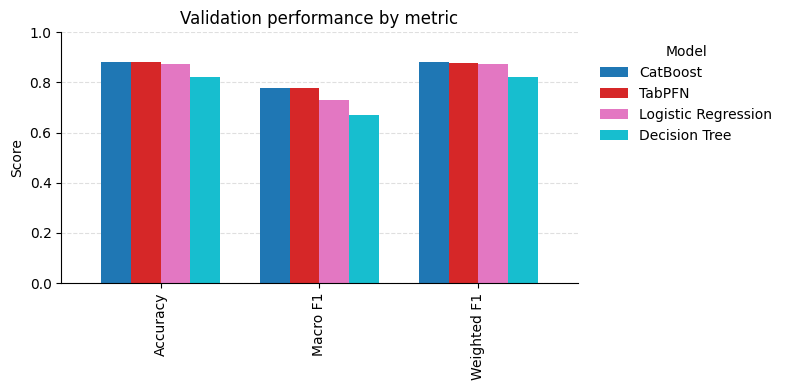

In [14]:
def _slugify_label(label):
    slug = re.sub(r"[^a-z0-9_]+", "", str(label).lower().replace(" ", "_")).strip("_")
    return slug or "class"


def build_metrics_row(model_name, y_true, y_pred, class_labels):
    y_true_arr = np.asarray(y_true)
    y_pred_arr = np.asarray(y_pred).squeeze()
    class_labels = [cls for cls in class_labels if cls in set(y_true_arr)]

    metrics_row = {
        "model": model_name,
        "accuracy": accuracy_score(y_true_arr, y_pred_arr),
        "macro_f1": f1_score(y_true_arr, y_pred_arr, average="macro"),
        "weighted_f1": f1_score(y_true_arr, y_pred_arr, average="weighted"),
    }

    report = classification_report(
        y_true_arr,
        y_pred_arr,
        labels=class_labels,
        output_dict=True,
        zero_division=0,
    )
    for cls in class_labels:
        class_key = _slugify_label(cls)
        metrics_row[f"f1_{class_key}"] = report[str(cls)]["f1-score"]
        true_mask = y_true_arr == cls
        per_class_acc = (y_pred_arr == cls) == true_mask
        metrics_row[f"accuracy_{class_key}"] = float(np.mean(per_class_acc))

    return metrics_row


model_registry = {
    "CatBoost": catboost_model,
    "Logistic Regression": logreg_model,
    "Decision Tree": decision_tree_model,
}
if USE_TABPFN and tabpfn_model is not None:
    model_registry["TabPFN"] = tabpfn_model

metrics_rows = []
for name, model_candidate in model_registry.items():
    pred = np.asarray(model_candidate.predict(X_valid)).squeeze()
    class_labels = getattr(model_candidate, "classes_", np.unique(y_valid))
    metrics_rows.append(
        build_metrics_row(name, y_valid, pred, class_labels)
    )

metrics_df = (
    pd.DataFrame(metrics_rows)
    .set_index("model")
    .sort_values("macro_f1", ascending=False)
)

metrics_dir = Path("metrics")
metrics_dir.mkdir(parents=True, exist_ok=True)
for model_name, row in metrics_df.iterrows():
    slug = _slugify_label(model_name)
    metrics_path = metrics_dir / f"iclr{EVAL_YEAR}_validation_{slug}.json"
    payload = {
        "model": model_name,
        "eval_year": int(EVAL_YEAR),
        "split": "validation",
        **{metric: float(value) for metric, value in row.items()},
    }
    with metrics_path.open("w", encoding="utf-8") as handle:
        json.dump(payload, handle, indent=2)

display(metrics_df.style.format("{:.3f}"))

metrics_plot = metrics_df[["accuracy", "macro_f1", "weighted_f1"]].rename(
    columns={
        "accuracy": "Accuracy",
        "macro_f1": "Macro F1",
        "weighted_f1": "Weighted F1",
    }
)

ax = metrics_plot.T.plot(
    kind="bar",
    figsize=(8, 4),
    width=0.75,
    colormap="tab10",
)
ax.set_title("Validation performance by metric")
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
ax.grid(axis="y", linestyle="--", alpha=0.4)
ax.set_axisbelow(True)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.legend(title="Model", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)
plt.tight_layout()
plt.show()

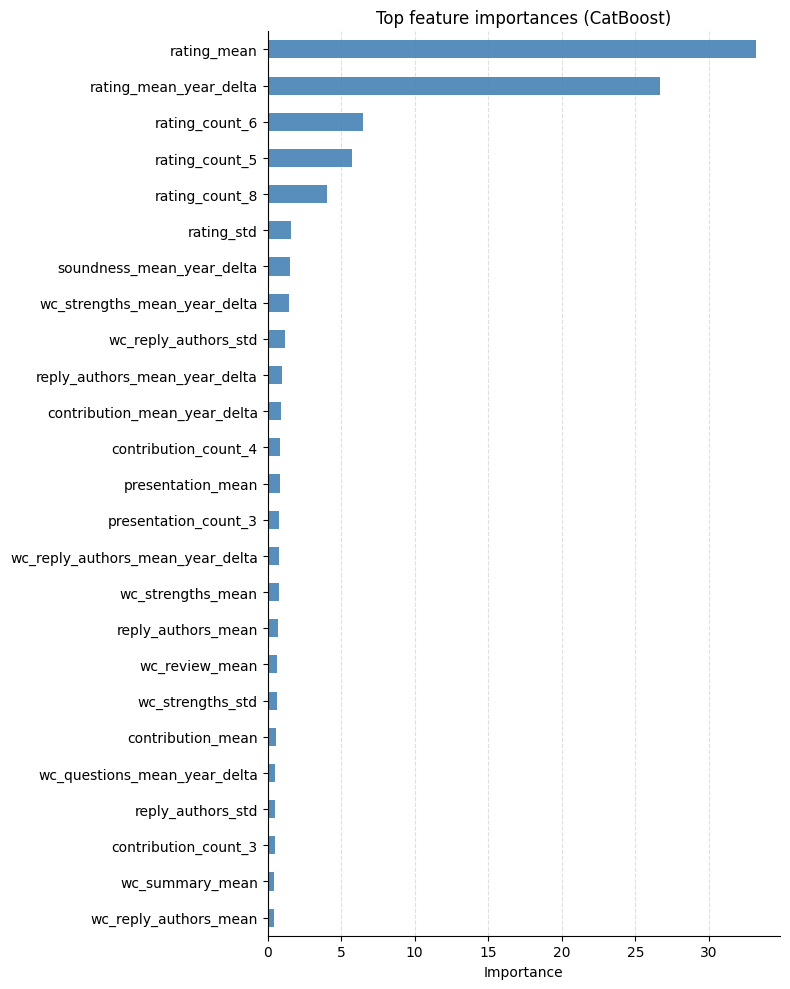

In [15]:
import matplotlib.pyplot as plt

feature_importance = pd.Series(
    model.get_feature_importance(),
    index=X_train_full.columns,
).sort_values(ascending=True)

TOP_N = 25
fig, ax = plt.subplots(figsize=(8, 10))
feature_importance.tail(TOP_N).plot(kind="barh", ax=ax, color="steelblue", alpha=0.9)
ax.set_title("Top feature importances (CatBoost)")
ax.set_xlabel("Importance")
ax.grid(axis="x", linestyle="--", alpha=0.4)
ax.set_axisbelow(True)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
plt.tight_layout()
plt.show()

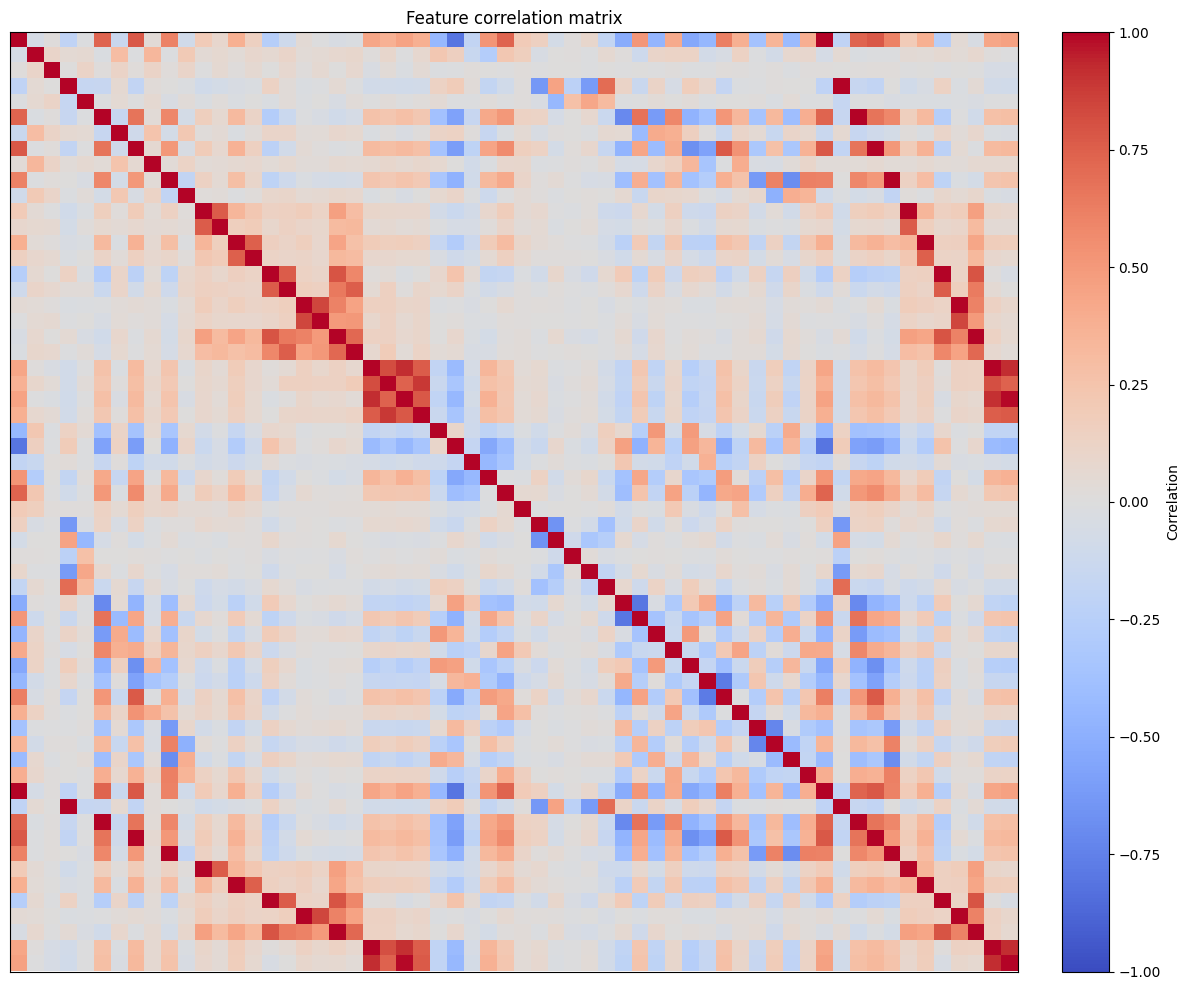

In [16]:
corr_matrix = X_train_full.corr()

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(
    corr_matrix,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax.set_title("Feature correlation matrix")
ax.set_xticks([])
ax.set_yticks([])
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Correlation")
plt.tight_layout()
plt.show()

In [17]:
X_eval.head()

,rating_mean,rating_std,rating_count,confidence_mean,confidence_std,soundness_mean,soundness_std,contribution_mean,contribution_std,presentation_mean,presentation_std,wc_summary_mean,wc_summary_std,wc_strengths_mean,wc_strengths_std,wc_weaknesses_mean,wc_weaknesses_std,wc_questions_mean,wc_questions_std,wc_review_mean,wc_review_std,wc_reply_authors_mean,wc_reply_authors_std,reply_authors_mean,reply_authors_std,rating_count_1,rating_count_3,rating_count_5,rating_count_6,rating_count_8,rating_count_10,confidence_count_3,confidence_count_4,confidence_count_1,confidence_count_2,confidence_count_5,soundness_count_2,soundness_count_3,soundness_count_1,soundness_count_4,contribution_count_1,contribution_count_2,contribution_count_3,contribution_count_4,presentation_count_2,presentation_count_3,presentation_count_1,presentation_count_4,rating_mean_year_delta,confidence_mean_year_delta,soundness_mean_year_delta,contribution_mean_year_delta,presentation_mean_year_delta,wc_summary_mean_year_delta,wc_strengths_mean_year_delta,wc_weaknesses_mean_year_delta,wc_questions_mean_year_delta,wc_review_mean_year_delta,wc_reply_authors_mean_year_delta,reply_authors_mean_year_delta
0,5.00,0.000000,4,4.000000,0.707107,2.500000,0.500000,1.75,0.433013,2.75,0.433013,76.250000,61.259183,54.500000,19.551215,217.25,125.168636,57.250000,39.983590,405.250000,89.429791,0.0,0.0,0.0,0.0,0.00,0.0,1.00,0.00,0.0,0.0,0.250000,0.500000,0.0,0.00,0.25,0.500000,0.500000,0.0,0.0,0.25,0.75,0.00,0.0,0.25,0.75,0.00,0.0,0.124978,0.375494,-0.043361,-0.591154,0.149595,-16.316968,-16.674009,23.745997,-24.022390,-33.267369,0.0,0.0
1,4.00,1.000000,4,3.250000,0.829156,2.500000,0.500000,2.00,0.000000,2.50,0.500000,106.000000,68.003676,69.000000,55.353410,114.50,37.792195,64.250000,56.397584,353.750000,202.200859,0.0,0.0,0.0,0.0,0.00,0.5,0.50,0.00,0.0,0.0,0.250000,0.500000,0.0,0.25,0.00,0.500000,0.500000,0.0,0.0,0.00,1.00,0.00,0.0,0.50,0.50,0.00,0.0,-0.875022,-0.374506,-0.043361,-0.341154,-0.100405,13.433032,-2.174009,-79.004003,-17.022390,-84.767369,0.0,0.0
2,4.25,1.299038,4,3.750000,0.433013,2.500000,0.500000,2.00,0.707107,2.50,0.500000,104.250000,41.044945,51.250000,19.904459,180.75,68.954242,101.750000,73.209887,438.000000,129.118163,0.0,0.0,0.0,0.0,0.00,0.5,0.25,0.25,0.0,0.0,0.250000,0.750000,0.0,0.00,0.00,0.500000,0.500000,0.0,0.0,0.25,0.50,0.25,0.0,0.50,0.50,0.00,0.0,-0.625022,0.125494,-0.043361,-0.341154,-0.100405,11.683032,-19.924009,-12.754003,20.477610,-0.517369,0.0,0.0
3,3.00,1.414214,4,4.500000,0.500000,1.750000,0.829156,1.25,0.433013,2.25,0.829156,26.750000,23.519938,26.750000,20.728905,96.50,37.138255,32.250000,30.260329,182.250000,104.855555,0.0,0.0,0.0,0.0,0.25,0.5,0.25,0.00,0.0,0.0,0.000000,0.500000,0.0,0.00,0.50,0.250000,0.250000,0.5,0.0,0.75,0.25,0.00,0.0,0.25,0.50,0.25,0.0,-1.875022,0.875494,-0.793361,-1.091154,-0.350405,-65.816968,-44.424009,-97.004003,-49.022390,-256.267369,0.0,0.0
4,5.00,0.000000,3,3.333333,0.471405,2.333333,0.471405,2.00,0.000000,3.00,0.000000,115.666667,37.392810,53.333333,10.964589,127.00,90.025922,50.333333,33.479679,346.333333,48.175605,0.0,0.0,0.0,0.0,0.00,0.0,1.00,0.00,0.0,0.0,0.666667,0.333333,0.0,0.00,0.00,0.666667,0.333333,0.0,0.0,0.00,1.00,0.00,0.0,0.00,1.00,0.00,0.0,0.124978,-0.291173,-0.210028,-0.341154,0.399595,23.099699,-17.840675,-66.504003,-30.939056,-92.184036,0.0,0.0


In [18]:
if EVAL_YEAR == 2026:
    # Adjust 2026 ratings for reduced review response time similar to adjustment of previous years
    X_eval["rating_mean_year_delta"] += 0.5
    X_eval["rating_mean"] += 0.5

classes = model_registry["CatBoost"].classes_

eval_ids = ids_by_year.get(EVAL_YEAR)
class_order = None

eval_results_by_model = {}
eval_summary_rows = []
eval_metrics_rows = []

for model_name, model_obj in model_registry.items():
    eval_proba = model_obj.predict_proba(X_eval)
    try:
        eval_labels = model_obj.predict(X_eval).squeeze()
    except Exception as e:
        print(f"Error predicting {model_name}: {e}")
        eval_labels = np.argmax(eval_proba, axis=1)


    if class_order is None:
        class_order = list(classes)

    results_eval = pd.DataFrame(
        {
            "id": eval_ids if eval_ids is not None else X_eval.index,
            "pred_status": eval_labels,
        }
    )

    for i, class_name in enumerate(classes):
        results_eval[f"proba_{class_name}"] = eval_proba[:, i]

    model_slug = model_name.lower().replace(" ", "_")
    results_eval.to_csv(
        PREDICTIONS_DIR / f"iclr{EVAL_YEAR}_{model_slug}_predictions.csv",
        index=False,
    )
    eval_results_by_model[model_name] = results_eval

    pred_counts = (
        results_eval["pred_status"]
        .value_counts()
        .reindex(classes, fill_value=0)
    )
    pred_dist = (pred_counts / pred_counts.sum()).rename("share")
    for cls_name, count in pred_counts.items():
        eval_summary_rows.append(
            {
                "model": model_name,
                "class": cls_name,
                "count": int(count),
                "share": float(pred_dist.loc[cls_name]),
            }
        )

    if EVAL_YEAR != 2026 and y_eval is not None:
        eval_mask = y_eval.notna()
        if eval_mask.any():
            eval_pred = pd.Series(eval_labels, index=X_eval.index)[eval_mask]
            print(f"ICLR {EVAL_YEAR} eval ({model_name}):")
            print(
                classification_report(
                    y_eval[eval_mask],
                    eval_pred,
                )
            )

            eval_row = build_metrics_row(
                model_name,
                y_eval[eval_mask],
                eval_pred,
                classes,
            )
            eval_metrics_rows.append(eval_row)

            eval_slug = _slugify_label(model_name)
            eval_metrics_path = metrics_dir / f"iclr{EVAL_YEAR}_eval_{eval_slug}.json"
            eval_payload = {
                "model": model_name,
                "eval_year": int(EVAL_YEAR),
                "split": "eval",
                **{
                    metric: float(value)
                    for metric, value in eval_row.items()
                    if metric != "model"
                },
            }
            with eval_metrics_path.open("w", encoding="utf-8") as handle:
                json.dump(eval_payload, handle, indent=2)


if eval_metrics_rows:
    eval_metrics_df = (
        pd.DataFrame(eval_metrics_rows)
        .set_index("model")
        .sort_values("macro_f1", ascending=False)
    )
    display(eval_metrics_df.style.format("{:.3f}"))


eval_summary_df = pd.DataFrame(eval_summary_rows)
eval_summary_df.to_csv(
    PREDICTIONS_DIR / f"iclr{EVAL_YEAR}_prediction_summary_by_model.csv",
    index=False,
)




model,CatBoost,Decision Tree,Logistic Regression,TabPFN
class,,,,
oral,0.003,0.020,0.000,0.007
poster,0.274,0.301,0.164,0.174
reject,0.697,0.630,0.809,0.795
spotlight,0.026,0.049,0.027,0.023


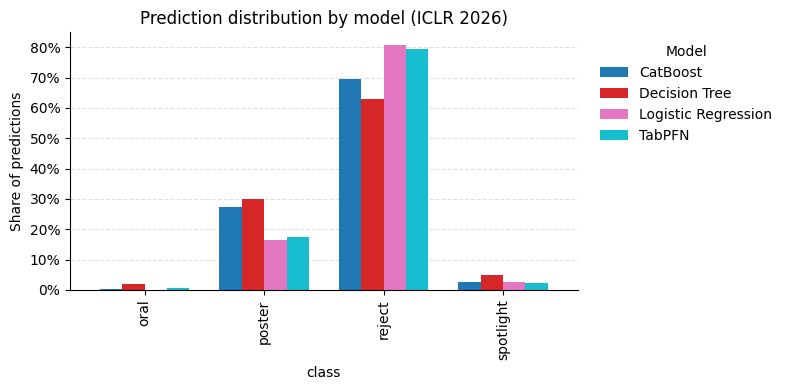

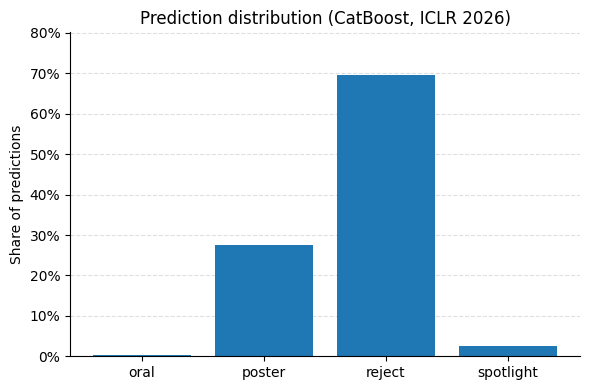

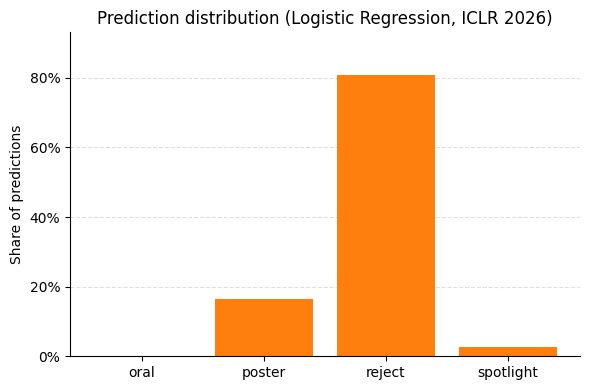

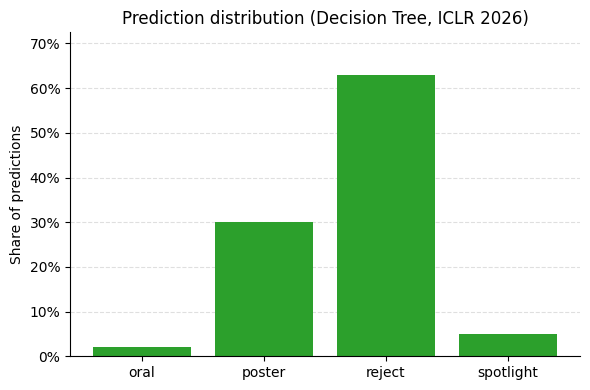

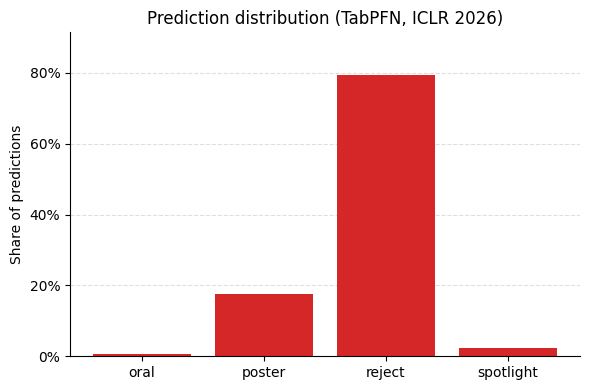

In [19]:
class_order = class_order or sorted(eval_summary_df["class"].unique())

summary_pivot = (
    eval_summary_df
    .pivot(index="class", columns="model", values="share")
    .reindex(class_order)
    .fillna(0)
)

display(summary_pivot.style.format("{:.3f}"))

# Combined visualization (grouped by class, colored by model)
ax = summary_pivot.plot(
    kind="bar",
    figsize=(8, 4),
    width=0.75,
    colormap="tab10",
)
ax.set_title(f"Prediction distribution by model (ICLR {EVAL_YEAR})")
ax.set_ylabel("Share of predictions")
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.grid(axis="y", linestyle="--", alpha=0.4)
ax.set_axisbelow(True)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.legend(title="Model", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)
plt.tight_layout()
plt.show()

# Individual model visualizations
colors = plt.get_cmap("tab10").colors
for idx, (model_name, results_eval) in enumerate(eval_results_by_model.items()):
    pred_counts = (
        results_eval["pred_status"]
        .value_counts()
        .reindex(class_order, fill_value=0)
    )
    pred_dist = (pred_counts / pred_counts.sum()).rename("share")

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.bar(class_order, pred_dist.values, color=colors[idx % len(colors)])
    ax.set_ylabel("Share of predictions")
    ax.set_title(f"Prediction distribution ({model_name}, ICLR {EVAL_YEAR})")
    ax.set_ylim(0, pred_dist.max() * 1.15)
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    ax.set_axisbelow(True)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    plt.tight_layout()
    plt.show()
